In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/PCB_QM

/content/gdrive/MyDrive/PCB_QM


In [4]:
import pandas as pd
import numpy as np
import cv2

In [5]:
import pickle

# 데이터 로드

In [6]:
csv_data = pd.read_csv('PCB_LABELING.csv')
prod1_data = csv_data[csv_data['prod_label'] == 1]
prod1_data.shape

(121, 4)

In [7]:
prod1_data

,Unnamed: 0,path,error_label,prod_label
0,0,./PCB_DATASET/PCB_USED/01.JPG,0,1
10,10,./PCB_DATASET/images/Missing_hole/01_missing_h...,1,1
11,11,./PCB_DATASET/images/Missing_hole/01_missing_h...,1,1
12,12,./PCB_DATASET/images/Missing_hole/01_missing_h...,1,1
13,13,./PCB_DATASET/images/Missing_hole/01_missing_h...,1,1
...,...,...,...,...
602,602,./PCB_DATASET/images/Spurious_copper/01_spurio...,6,1
603,603,./PCB_DATASET/images/Spurious_copper/01_spurio...,6,1
604,604,./PCB_DATASET/images/Spurious_copper/01_spurio...,6,1
605,605,./PCB_DATASET/images/Spurious_copper/01_spurio...,6,1


In [8]:
img_paths = prod1_data.path
labels = prod1_data.error_label

In [9]:
normal_img_paths = img_paths[labels == 0]
fault_img_paths = img_paths[labels != 0]

In [10]:
fault_label = labels[labels != 0]

In [9]:
print(normal_img_paths.shape)
print(fault_img_paths.shape)

(1,)
(120,)


In [ ]:
img = cv2.imread(normal_img_paths[0])
print(img)

[[[140 136 147]
  [140 137 146]
  [136 134 140]
  ...
  [156 152 158]
  [151 147 153]
  [153 149 155]]

 [[138 137 146]
  [137 136 145]
  [137 136 145]
  ...
  [153 149 155]
  [150 146 152]
  [153 149 155]]

 [[139 140 150]
  [141 140 150]
  [143 142 152]
  ...
  [153 149 155]
  [148 144 150]
  [154 150 156]]

 ...

 [[136 135 139]
  [142 138 143]
  [142 135 142]
  ...
  [153 147 152]
  [152 146 151]
  [154 148 153]]

 [[145 138 145]
  [141 134 141]
  [143 136 143]
  ...
  [153 148 149]
  [151 146 148]
  [154 149 151]]

 [[145 139 144]
  [142 136 141]
  [144 137 144]
  ...
  [155 150 151]
  [156 150 155]
  [158 152 157]]]


# 패치 생성


In [46]:
def create_patches_with_positions(image, patch_size=(64, 64)):
    patches = []
    positions = []
    for i in range(0, image.shape[0] - patch_size[0] + 1, patch_size[0]):
        for j in range(0, image.shape[1] - patch_size[1] + 1, patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]]
            patches.append(patch)
            positions.append((i, j))
    return np.array(patches), positions

# 예제 데이터 로드 (이미지와 라벨)

In [47]:
normal_img_paths[0]
normal_image = cv2.imread(normal_img_paths[0])  # 하나의 정상 이미지 선택

In [48]:

# 패치 생성
patch_size = (64, 64)
normal_image = cv2.resize(normal_image,(512,512))
normal_patches, normal_positions = create_patches_with_positions(normal_image, patch_size)



In [49]:
normal_patches.shape

(64, 64, 64, 3)

In [50]:

fault_patches_list = []
fault_positions_list = []
for fault_img_path in fault_img_paths:
    fault_image= cv2.imread(fault_img_path)
    fault_image = cv2.resize(fault_image,(512,512))
    patches, positions = create_patches_with_positions(fault_image, patch_size)
    fault_patches_list.append(patches)
    fault_positions_list.append(positions)

KeyboardInterrupt: 

In [ ]:
print(len(fault_patches_list))
fault_patches_list[0].shape

In [ ]:
pk_data = {'normal_patches' : normal_patches,
           'fault_patches_list' : fault_patches_list}

with open('pathes_temp.pickle','wb') as file :
    pickle.dump(pk_data,file)

In [11]:
with open('pathes_temp.pickle','rb') as file :
    pk_data = pickle.load(file)
normal_patches = pk_data['normal_patches']
fault_patches_list = pk_data['fault_patches_list']

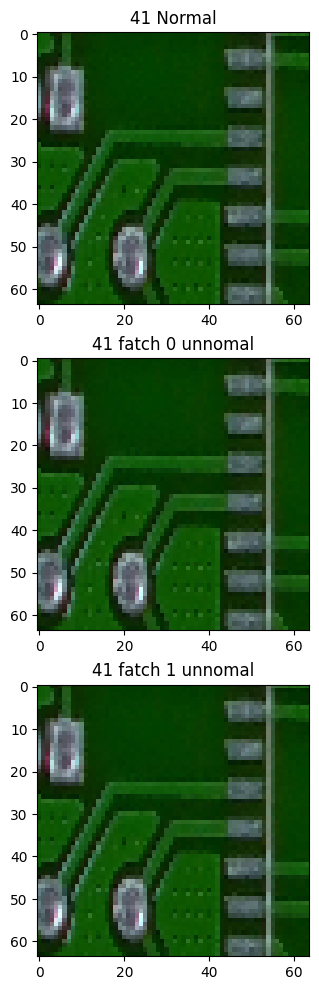

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))

from random import sample

row = 0
patch_sample = 1

for patch in sample(range(41, 42), patch_sample):
    col = 1
    plt.subplot(3, patch_sample, row * 3 + col)
    plt.imshow(normal_patches[patch])
    plt.title(f'{patch} Normal')

    for fault in sample(range(0, 2), 2):
        col +=1
        plt.subplot(3, patch_sample, row * 3 + col)
        plt.imshow(fault_patches_list[fault][patch])
        plt.title(f'{patch} fatch {fault} unnomal')
    row+=1


# 학습

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2
)

In [ ]:
def augment_patches(patches, augment_size=5):
    augmented_patches = []
    for patch in patches:
        patch = np.expand_dims(patch, axis=0)
        it = datagen.flow(patch, batch_size=1)
        for i in range(augment_size):  # 각 패치당 augment_size개의 증강된 패치 생성
            augmented_patches.append(it.next()[0])
    return np.array(augmented_patches)

In [ ]:
# 정상 패치 증강
augmented_normal_patches = augment_patches(normal_patches)

In [ ]:
# 라벨 생성 (정상: 0, 결함: 1)
normal_labels = np.zeros(len(augmented_normal_patches))
fault_labels = np.ones(len(fault_patches))

In [ ]:

print(normal_patches.shape)
print(augmented_normal_patches.shape)
print(fault_patches.shape)

(64, 64, 64, 3)
(320, 64, 64, 3)
(7680, 64, 64, 3)


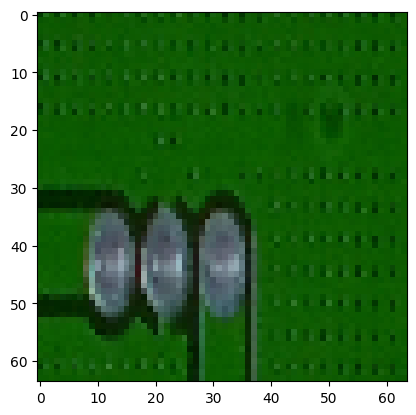

In [37]:
plt.imshow(normal_patches[10])

In [ ]:
# 데이터셋 병합
X = np.concatenate((augmented_normal_patches, fault_patches), axis=0)
y = np.concatenate((normal_labels, fault_labels), axis=0)

In [ ]:
# 데이터 섞기
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

In [ ]:
X.shape

(8000, 64, 64, 3)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


NameError: name 'patch_size' is not defined

In [ ]:
input_size = X[0].shape

In [ ]:

# 모델 정의
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_size),  # 3 채널 입력
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:

# 모델 학습
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
225/225 [==============================] - 7s 9ms/step - loss: 0.5370 - accuracy: 0.9707 - val_loss: 0.0244 - val_accuracy: 0.9950
Epoch 2/10
225/225 [==============================] - 1s 6ms/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0.0158 - val_accuracy: 0.9962
Epoch 3/10
225/225 [==============================] - 1s 5ms/step - loss: 0.0157 - accuracy: 0.9968 - val_loss: 0.0147 - val_accuracy: 0.9962
Epoch 4/10
225/225 [==============================] - 1s 5ms/step - loss: 0.0113 - accuracy: 0.9979 - val_loss: 0.0877 - val_accuracy: 0.9825
Epoch 5/10
225/225 [==============================] - 1s 5ms/step - loss: 0.0052 - accuracy: 0.9989 - val_loss: 0.0070 - val_accuracy: 0.9987
Epoch 6/10
225/225 [==============================] - 1s 5ms/step - loss: 3.1146e-04 - accuracy: 0.9999 - val_loss: 0.0086 - val_accuracy: 0.9987
Epoch 7/10
225/225 [==============================] - 1s 5ms/step - loss: 4.4172e-05 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 0.998

In [ ]:
import matplotlib.pyplot as plt

def visualize_fault_patches(image, patch_size, patches, positions, predictions, threshold=0.8):
    """
    이미지에서 결함이 검출된 패치를 시각화합니다.

    Args:
    - image: 원본 이미지 (numpy array)
    - patch_size: 패치 크기 (tuple)
    - patches: 분할된 패치들 (numpy array)
    - positions: 각 패치의 시작 위치 (list of tuples)
    - predictions: 모델 예측값 (numpy array)
    - threshold: 결함 여부를 판단하는 임계값 (float)
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    for pos, pred in zip(positions, predictions):
        if pred >= threshold:
            rect = plt.Rectangle(pos, patch_size[1], patch_size[0], linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
    plt.show()

In [ ]:
def create_patches_with_positions(images, patch_size=(64, 64)):
    patches = []
    positions = []
    for img in images:
        img = cv2.resize(img, (512,512)) # 기본 512,512 사이즈로 변경
        for i in range(0, img.shape[0] - patch_size[0] + 1, patch_size[0]):
            for j in range(0, img.shape[1] - patch_size[1] + 1, patch_size[1]):
                patch = img[i:i+patch_size[0], j:j+patch_size[1]]
                patches.append(patch)
                positions.append((i, j))
    return np.array(patches), positions

./PCB_DATASET/images/Missing_hole/01_missing_hole_01.jpg


./PCB_DATASET/PCB_USED/01.JPG


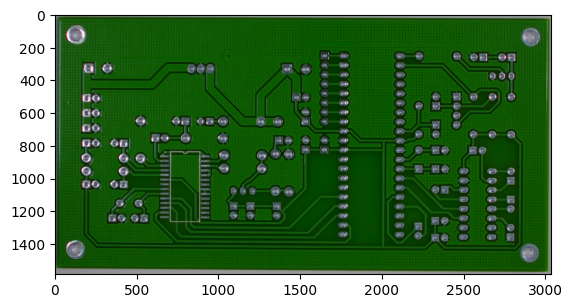

In [ ]:
# 예제: 하나의 이미지에서 패치 생성 및 예측 수행
img_path = img_paths[0]
print(img_path)
test_image = cv2.imread(img_path)  # 테스트할 이미지
plt.imshow(test_image)

2/2 [==============================] - 0s 15ms/step
[[1.        ]
 [0.9999988 ]
 [0.999997  ]
 [0.99999297]
 [0.9999931 ]
 [0.9999999 ]
 [1.        ]
 [0.9999999 ]
 [1.        ]
 [0.9999814 ]
 [0.9999994 ]
 [0.99999285]
 [1.        ]
 [0.9999993 ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.9999949 ]
 [0.9999865 ]
 [0.99999356]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.99999666]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.9999999 ]
 [1.        ]
 [1.        ]
 [0.99999964]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.9999994 ]
 [0.9999994 ]
 [0.99999917]
 [1.        ]
 [1.        ]
 [0.9999999 ]
 [1.        ]
 [1.        ]
 [0.99999976]
 [0.9999976 ]
 [0.9999999 ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.99999714]
 [0.99999416]
 [0.99999166]
 [0.9999982 ]
 [0.99998367]
 [0.99999213]
 [0.99999976]]


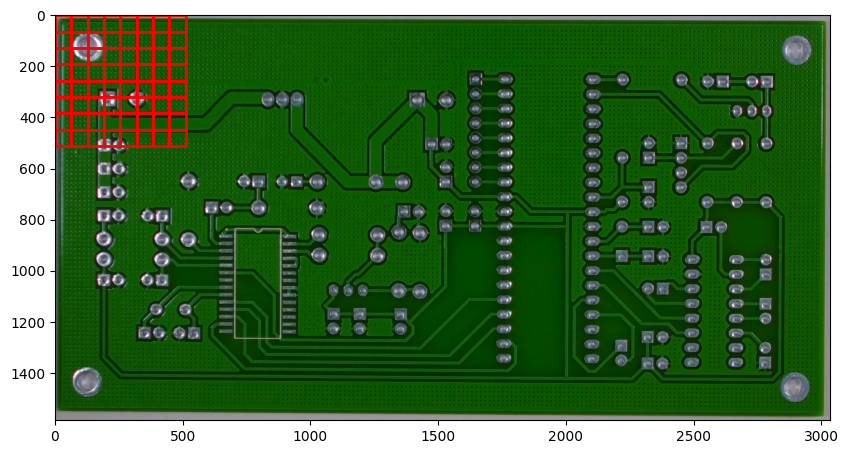

In [ ]:

patches, positions = create_patches_with_positions([test_image], patch_size)
predictions = model.predict(patches)
print(predictions)
# 결함 패치 시각화
visualize_fault_patches(test_image, patch_size, patches, positions, predictions)

# 단순 정상과 비교

In [14]:
def compare_patches(normal_patches, fault_patches_list, threshold=30):
    different_patches = []
    different_positions = []

    for fault_patches, fault_positions in zip(fault_patches_list, fault_positions_list):
        for i, (normal_patch, fault_patch) in enumerate(zip(normal_patches, fault_patches)):
            # 패치 간 차이 계산 (예: MSE)
            difference = np.mean((normal_patch - fault_patch) ** 2)
            if difference > threshold:
                different_patches.append(fault_patch)
                different_positions.append(fault_positions[i])

    return different_patches, different_positions

In [15]:
def visualize_different_patches(image, patch_size, different_positions):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    for pos in different_positions:
        rect = plt.Rectangle(pos, patch_size[1], patch_size[0], linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
    plt.show()


In [32]:
# 패치 비교
different_patches, different_positions = compare_patches(normal_patches, fault_patches_list,20)

In [33]:
print(different_patches)

[array([[[136, 135, 144],
        [141, 137, 148],
        [140, 136, 147],
        ...,
        [146, 145, 154],
        [142, 141, 151],
        [142, 141, 150]],

       [[134, 133, 143],
        [141, 140, 150],
        [141, 140, 150],
        ...,
        [144, 146, 151],
        [137, 139, 147],
        [138, 139, 146]],

       [[136, 136, 147],
        [138, 139, 149],
        [136, 138, 148],
        ...,
        [143, 148, 152],
        [138, 142, 148],
        [137, 141, 146]],

       ...,

       [[ 91, 103, 113],
        [ 87, 105, 112],
        [ 65,  96,  84],
        ...,
        [ 21,  92,   6],
        [ 22,  91,  10],
        [ 19,  91,   7]],

       [[ 88, 100, 109],
        [ 86, 102, 113],
        [ 68,  92,  84],
        ...,
        [ 15,  85,   2],
        [ 27,  93,  14],
        [ 18,  86,   7]],

       [[ 91, 102, 111],
        [ 86, 104, 111],
        [ 68,  95,  81],
        ...,
        [ 17,  90,   6],
        [ 27,  88,  23],
        [ 34, 100,  28]

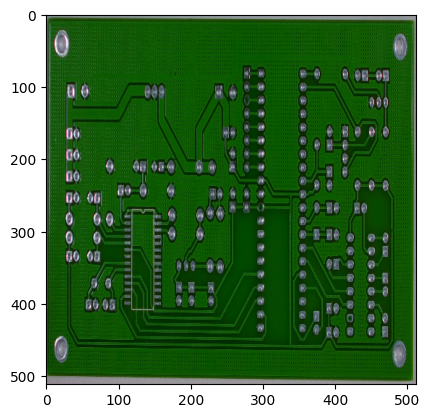

In [24]:
import matplotlib.pyplot as plt

# 예제: 하나의 결함 이미지에서 결함 위치 시각화
fault_image = cv2.imread(fault_img_paths[10]) # 테스트할 결함 이미지
fault_image = cv2.resize(fault_image,(512,512))
plt.imshow(fault_image)

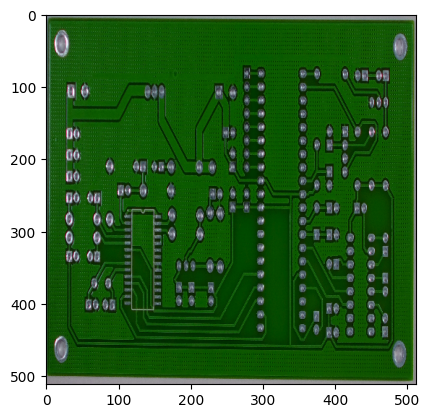

In [27]:
plt.imshow(normal_image)

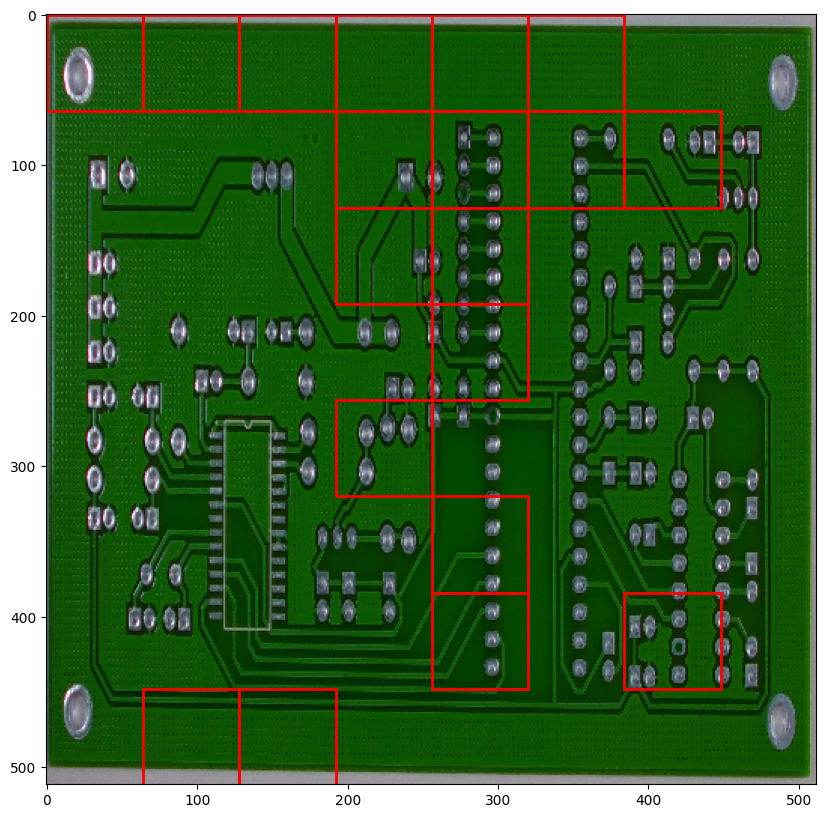

In [34]:

visualize_different_patches(fault_image, patch_size, different_positions)

# 비지도 유사성 비교


In [14]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

def extract_color_histogram(patch):
    """Extract color histogram from a patch."""
    hist = cv2.calcHist([patch], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_features(patches):
    """Extract features from all patches."""
    features = []
    for patch in patches:
        hist = extract_color_histogram(patch)
        features.append(hist)
    return np.array(features)

# 정상 이미지 패치에서 특징 추출
normal_features = extract_features(normal_patches)

# 결함 이미지 패치에서 특징 추출
fault_features_list = [extract_features(patches) for patches in fault_patches_list]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

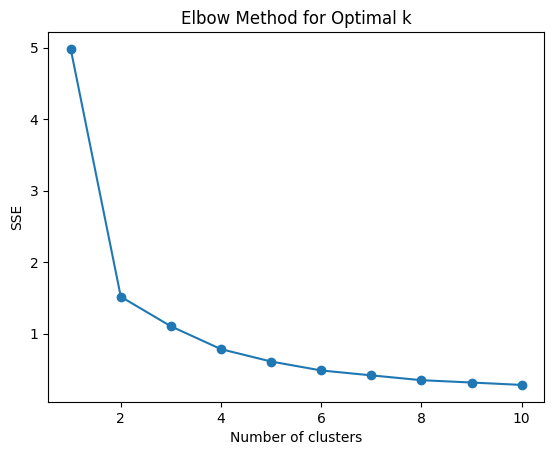

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def find_optimal_clusters_elbow(features, max_clusters=10):
    sse = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(features)
        sse.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters+1), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title('Elbow Method for Optimal k')
    plt.show()

# 정상 이미지의 특징을 사용하여 최적의 클러스터 수 찾기
find_optimal_clusters_elbow(normal_features)


In [16]:
def cluster_features(features, n_clusters=8):
    """Cluster features using K-means."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(features)
    return kmeans

# 정상 이미지의 특징을 클러스터링
n_clusters = 2
kmeans = cluster_features(normal_features, n_clusters=n_clusters)
kmeans.fit(normal_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=0)

In [17]:
def compare_patches(normal_kmeans, fault_features):
    """Compare fault patches with normal patches."""
    similarities = []
    for features in fault_features:
        if features.ndim == 1:
            features = features.reshape(1, -1)
        distances = normal_kmeans.transform(features)
        min_distances = np.min(distances, axis=1)
        similarities.append(min_distances)
    return similarities

# 결함 이미지 패치와 정상 이미지 패치 비교
similarities_list = [compare_patches(kmeans, features) for features in fault_features_list]

# 결과 출력
# for i, similarities in enumerate(similarities_list):
#     print(f"Fault Image {i+1} Patch Similarities: {similarities}")


Fault Image 1 Patch Similarities: [array([0.22628367], dtype=float32), array([0.16255961], dtype=float32), array([0.15711664], dtype=float32), array([0.1531974], dtype=float32), array([0.14788759], dtype=float32), array([0.1465649], dtype=float32), array([0.1528511], dtype=float32), array([0.30005693], dtype=float32), array([0.15450855], dtype=float32), array([0.13594286], dtype=float32), array([0.1046811], dtype=float32), array([0.11244001], dtype=float32), array([0.236351], dtype=float32), array([0.1802467], dtype=float32), array([0.17129105], dtype=float32), array([0.07264741], dtype=float32), array([0.12366495], dtype=float32), array([0.11402323], dtype=float32), array([0.11420186], dtype=float32), array([0.08243448], dtype=float32), array([0.14387111], dtype=float32), array([0.09257445], dtype=float32), array([0.04967819], dtype=float32), array([0.05005257], dtype=float32), array([0.13999085], dtype=float32), array([0.08724689], dtype=float32), array([0.13194412], dtype=float32), 

In [85]:
# Calculate similarities for the normal image patches
normal_similarities = compare_patches(kmeans, normal_features)
normal_similarities[41]

array([0.30538133], dtype=float32)

In [ ]:
# 결과 출력
for i, similarities in enumerate(similarities_list):
    print(f"Fault Image {i+1} 41 Patch Similarities: {similarities[12]}")

In [18]:
# def find_different_patches(normal_similarities, fault_similarities, threshold=1.0):
#     """Find patches with significantly different similarity values compared to normal."""
#     different_patches = []
#     for idx, (normal_sim, fault_sim) in enumerate(zip(normal_similarities, fault_similarities)):
#         if abs(normal_sim - fault_sim) > threshold:
#             different_patches.append(idx)
#     return different_patches

def find_different_patches(similarities_list, threshold=1.0):
    """Find patches with significantly different similarity values."""
    different_patches = []
    num_patches = len(similarities_list[0])
    # Calculate mean and std for each patch index across all similarities
    sim_all_values = [[sim[idx] for sim in similarities_list] for idx in range(num_patches)]
    print(np.array(sim_all_values).shape)
    for similarities in similarities_list :
        different_patche = []
        for idx in range(num_patches):
            if abs(similarities[idx] - np.mean(sim_all_values[idx])) > threshold:
                different_patche.append(idx)
        different_patches.append(different_patche)
    return different_patches

# def find_different_patches(similarities_list, threshold=1.0):
#     """Find patches with significantly different similarity values."""
#     different_patches = set()
#     num_patches = len(similarities_list[0])

#     # Calculate mean and std for each patch index across all similarities
#     sim_all_values = np.array(similarities_list).T
#     means = np.mean(sim_all_values, axis=1)
#     std_devs = np.std(sim_all_values, axis=1)

#     # Find patches that differ significantly
#     for similarities in similarities_list:
#         for idx in range(num_patches):
#             if abs(similarities[idx] - means[idx]) > threshold * std_devs[idx]:
#                 different_patches.add(idx)


In [19]:
different_patches_indices = find_different_patches(similarities_list, threshold=0.008)
len_diff_list = [len(diff) for diff in different_patches_indices]
max_len = max(len_diff_list)
different_patches_indices

(64, 120, 1)


[[12],
 [38],
 [],
 [12],
 [20],
 [],
 [12, 43],
 [55],
 [27],
 [20],
 [29],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [12, 15, 22, 29, 34, 35, 38, 39, 42, 45, 47, 50, 51, 61],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [43],
 [],
 [],
 [],
 [],
 [50],
 [],
 [],
 [],
 [20],
 [],
 [],
 [33],
 [37],
 [],
 [13],
 [33],
 [],
 [20, 29],
 [33],
 [50],
 [],
 [12],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [42],
 [20, 41],
 [36],
 [29],
 [41],
 [22, 28, 42],
 [30, 38],
 [45],
 [36, 43, 53],
 [50, 51],
 [42, 55],
 [46, 55],
 [13, 30],
 [28, 43, 50],
 [33, 41, 43],
 [20],
 [53, 61],
 [36, 43, 50],
 [41],
 [39, 44]]

In [140]:
fault_label.shape

(120,)

In [21]:
normal_patches.shape

(64, 64, 64, 3)

array([[[10, 75,  0],
        [ 8, 90,  1],
        [11, 92,  0],
        ...,
        [ 9, 84,  1],
        [13, 92,  0],
        [16, 94,  0]],

       [[ 3, 63,  0],
        [13, 91,  0],
        [14, 93,  1],
        ...,
        [ 1, 46,  0],
        [11, 89,  1],
        [13, 89,  0]],

       [[10, 82,  0],
        [13, 91,  0],
        [ 9, 90,  0],
        ...,
        [ 1, 70,  0],
        [12, 87,  0],
        [21, 99,  1]],

       ...,

       [[10, 91,  0],
        [11, 91,  0],
        [13, 95,  1],
        ...,
        [14, 90,  0],
        [ 7, 87,  0],
        [13, 91,  1]],

       [[11, 91,  0],
        [ 9, 92,  0],
        [ 9, 90,  0],
        ...,
        [ 0, 54,  0],
        [11, 90,  0],
        [ 1, 63,  0]],

       [[10, 89,  1],
        [ 9, 91,  0],
        [ 8, 90,  0],
        ...,
        [ 6, 76,  1],
        [ 8, 86,  0],
        [14, 94,  2]]], dtype=uint8)
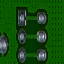

In [23]:
normal_patches[12]

Fault Image 1 --- Different Patch Index: 12


KeyError: 0

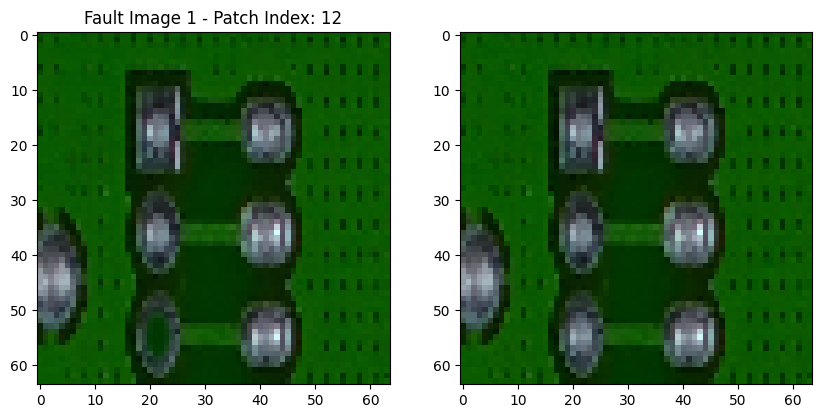

In [20]:

# 결과 출력 및 시각화
for i, fault_patches in enumerate(fault_patches_list):
    for idx in different_patches_indices[i]:
        plt.figure(figsize=(10, 5))
        print(f"Fault Image {i+1} --- Different Patch Index: {idx}")

        # Fault Patch 이미지 출력
        plt.subplot(1, 2, 1)
        plt.imshow(fault_patches[idx])
        plt.title(f"Fault Image {i+1} - Patch Index: {idx}")

        # Normal Patch 이미지 출력
        plt.subplot(1, 2, 2)
        plt.imshow(normal_patches[idx])
        plt.title(f'{idx} Normal : fault code {fault_label[i]}')

        plt.show()

In [87]:
for i, fault_features in enumerate(fault_features_list[:10]):
    fault_similarities = compare_patches(kmeans, fault_features)
    different_patches_indices = find_different_patches(normal_similarities, fault_similarities, threshold=0.015)

    print(f"Fault Image {i+1} - Different Patch Indices: {different_patches_indices}")

    for idx in different_patches_indices:
        plt.imshow(cv2.cvtColor(fault_patches_list[i][idx], cv2.COLOR_BGR2RGB))
        plt.title(f"Fault Image {i+1} - Patch Index: {idx}")
        plt.show()

TypeError: find_different_patches() missing 1 required positional argument: 'fault_similarities'